### 1) Загружаем библиотеки, списки пунктуации и стоп-слов

In [1]:
from string import punctuation
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


---

### 2) Загружаем датасет и выводим его вид, основные топики

In [2]:
blog = pd.read_csv('blogtext.csv')

In [3]:
blog.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [4]:
topics = blog['topic'].unique()
topics

array(['Student', 'InvestmentBanking', 'indUnk', 'Non-Profit', 'Banking',
       'Education', 'Engineering', 'Science', 'Communications-Media',
       'BusinessServices', 'Sports-Recreation', 'Arts', 'Internet',
       'Museums-Libraries', 'Accounting', 'Technology', 'Law',
       'Consulting', 'Automotive', 'Religion', 'Fashion', 'Publishing',
       'Marketing', 'LawEnforcement-Security', 'HumanResources',
       'Telecommunications', 'Military', 'Government', 'Transportation',
       'Architecture', 'Advertising', 'Agriculture', 'Biotech',
       'RealEstate', 'Manufacturing', 'Construction', 'Chemicals',
       'Maritime', 'Tourism', 'Environment'], dtype=object)

### 3) Делаем предобработку — устраняем знаки пунктуации, убираем стоп-слова и "слова", состоящие не только из букв. Обучаем модель W2V

In [5]:
discard_punctuation_and_lowercased_sents_blog = [[word.lower() for word in sent.split(" ") if word not in punctuation 
                                             and word.lower() not in stopWords and word.isalpha()] # letters
                                            for sent in blog['text']]

w2v_blog = Word2Vec(discard_punctuation_and_lowercased_sents_blog, min_count=5, size=200, iter=10)
word_vectors_blog = w2v_blog.wv

w2v_blog.save("word2vec_no_stops.model") # сохраним для экономии времени в дальнейшем

C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


---

### 4) Рассмотрим обученную модель, проверим нахождение ближайших слов

In [6]:
model_pure = w2v_blog

In [7]:
model_pure.most_similar(['pain'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('pains', 0.6996392607688904),
 ('anguish', 0.6410577893257141),
 ('agony', 0.6406270265579224),
 ('numb', 0.6343631744384766),
 ('ache', 0.6341911554336548),
 ('discomfort', 0.6297481060028076),
 ('nausea', 0.6229159832000732),
 ('aches', 0.6225368976593018),
 ('hurts', 0.6217509508132935),
 ('hurt', 0.6171345114707947)]

### 5) Уменьшим размерность пространства методом TSNE и построим 100 наиболее часто встречающихся слов

In [8]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.index2entity[:100]:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=100, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


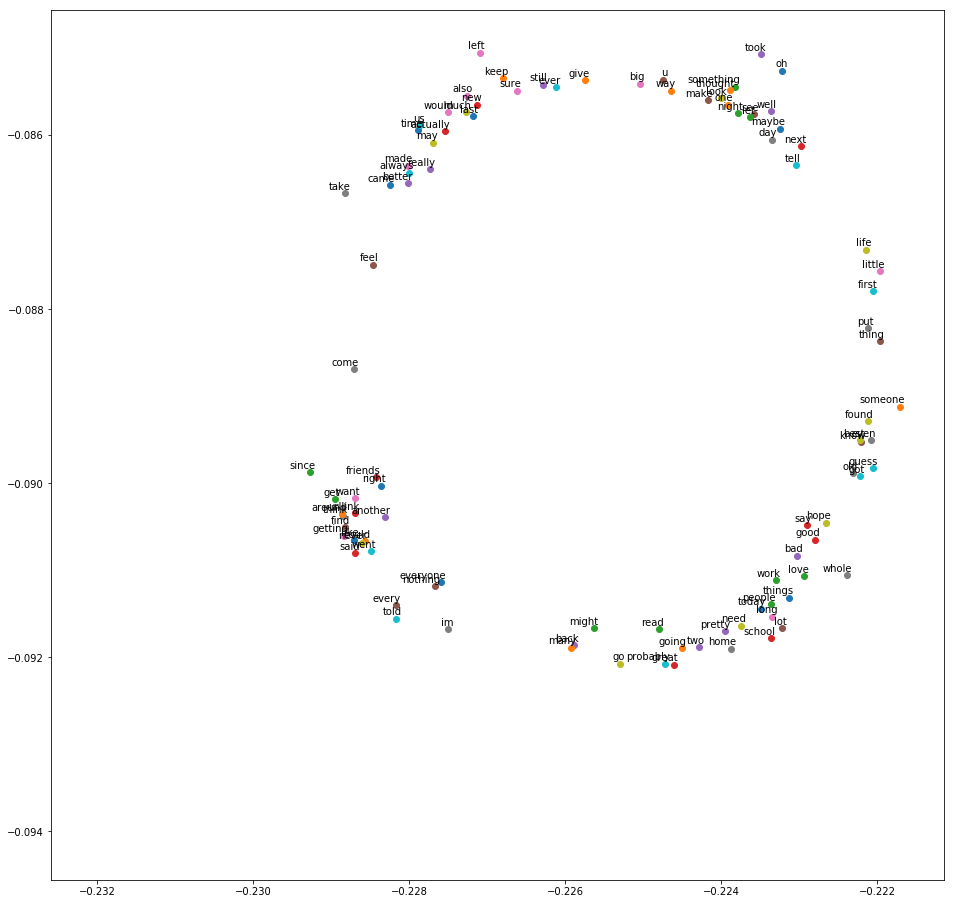

In [9]:
tsne_plot(model_pure)

### 6) Видим, что распределение не несет смысла — т.к. самые популярные слова служебные. Поскольку знаем темы блогов из датасета — используем их (сначала преобразуем в простые слова, которые точно будут в словаре, это можно сделать вручную). Так темы станут конкретнее и их будет меньше. 

In [10]:
keys = ['student', 'science', 'media', 'business', 'sport', 'art', 'internet', 'book', 'finance', 'law', 
        'war', 'architecture', 'tourism', 'environment', 'sea',
        'car', 'fashion', 'religion', 'government']

### 7) Отобразим пространство слов на 2D графике, построим для каждого ключевого слова (темы) 10 к нему ближайших слов в словаре.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all 

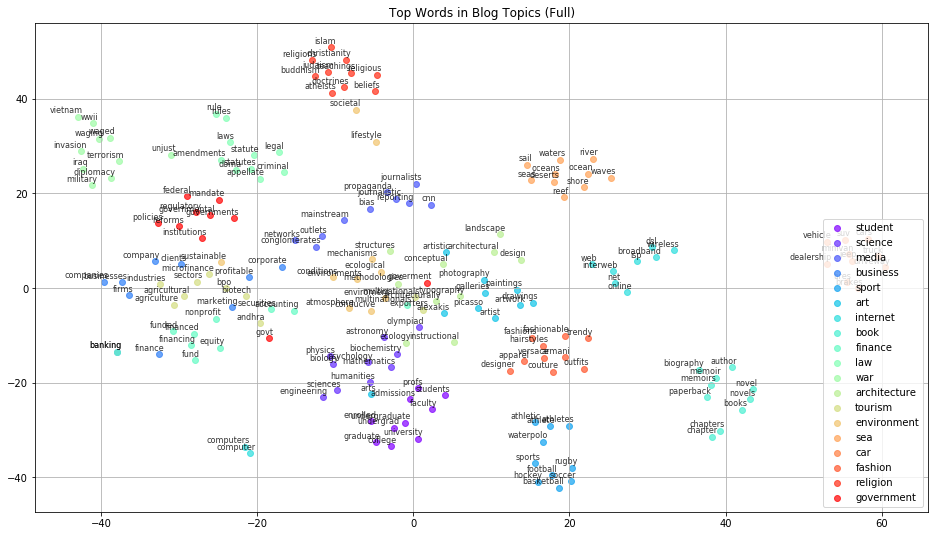

In [11]:
model = model_pure

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.8, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Top Words in Blog Topics (Full)', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

### 8) Изучим возрастную зависимость «карты слов». Разобьем датасет на 3 части в зависимости от принадлежности к возрастной группе (13-17, 23-28 и 33-47 лет — 10s, 20s и 30s соответственно).

In [12]:
blog['age'].unique()

array([15, 33, 14, 25, 17, 23, 37, 26, 24, 27, 45, 34, 41, 44, 16, 39, 35,
       36, 46, 42, 13, 38, 43, 40, 47, 48], dtype=int64)

In [13]:
# row in which value of 'age' column satisfy the condition
blog_10 = blog.apply(lambda x: True if x['age'] < 19 else False , axis=1)
blog_20 = blog.apply(lambda x: True if x['age'] > 20 and x['age'] < 30 else False , axis=1)
blog_30 = blog.apply(lambda x: True if x['age'] > 30 else False , axis=1)

In [14]:
blog[blog_10==True].head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
74,3539003,female,14,indUnk,Aries,"07,June,2004",O= optimist P= pessimist My...


In [15]:
# check the len 
len(blog[blog_30==True])+len(blog[blog_20==True])+len(blog[blog_10==True])-len(blog)

0

### 9) Обучим отдельно модели на каждой возрастной группе и построим графики

#### 9.1) Поколение 10s

In [16]:
discard_punctuation_and_lowercased_sents_blog10 = [[word.lower() for word in sent.split(" ") if word not in punctuation 
                                             and word.lower() not in stopWords and word.isalpha()] # letters
                                            for sent in blog[blog_10==True]['text']]

w2v_blog10 = Word2Vec(discard_punctuation_and_lowercased_sents_blog10, min_count=5, size=200, iter=10)
word_vectors_blog10 = w2v_blog10.wv
#len(word_vectors_blog.vocab)

w2v_blog10.save("word2vec_10s.model")

C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all 

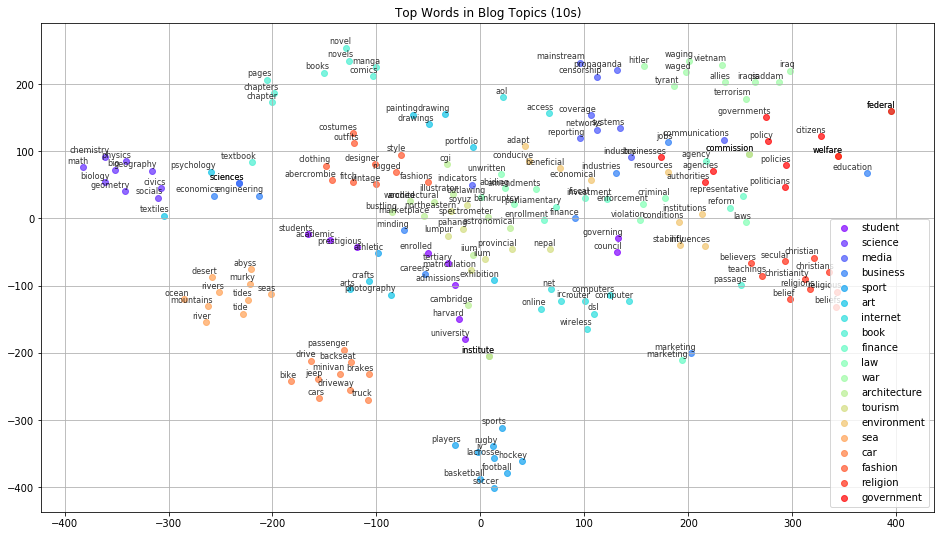

In [17]:
model = w2v_blog10

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.8, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Top Words in Blog Topics (10s)', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

#### 9.2) Поколение 20s

In [18]:
discard_punctuation_and_lowercased_sents_blog20 = [[word.lower() for word in sent.split(" ") if word not in punctuation 
                                             and word.lower() not in stopWords and word.isalpha()] # letters
                                            for sent in blog[blog_20==True]['text']]

w2v_blog20 = Word2Vec(discard_punctuation_and_lowercased_sents_blog20, min_count=5, size=200, iter=10)
word_vectors_blog20 = w2v_blog20.wv
#len(word_vectors_blog.vocab)

w2v_blog20.save("word2vec_20s.model")

C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all 

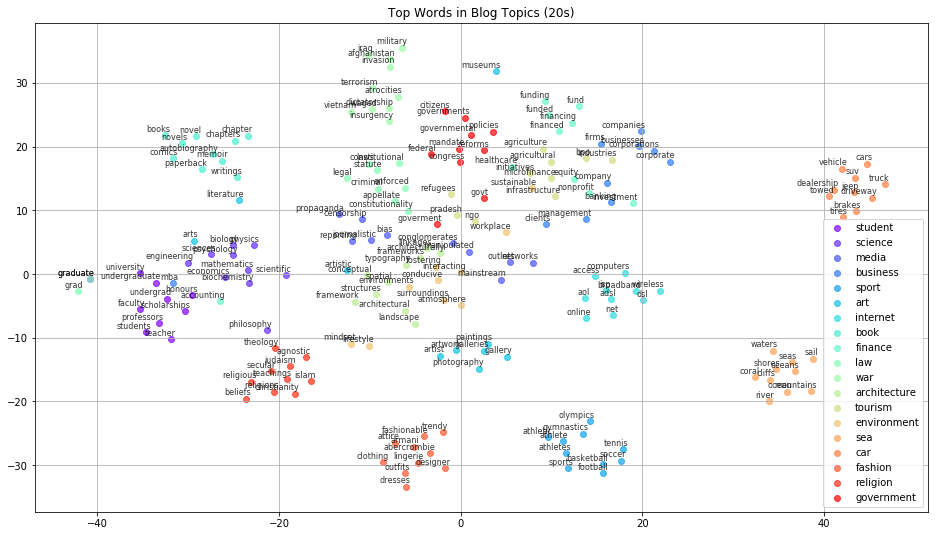

In [19]:
model = w2v_blog20

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.8, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Top Words in Blog Topics (20s)', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

#### 9.3) Поколение 30s

In [20]:
discard_punctuation_and_lowercased_sents_blog30 = [[word.lower() for word in sent.split(" ") if word not in punctuation 
                                             and word.lower() not in stopWords and word.isalpha()] # letters
                                            for sent in blog[blog_30==True]['text']]

w2v_blog30 = Word2Vec(discard_punctuation_and_lowercased_sents_blog30, min_count=5, size=200, iter=10)
word_vectors_blog30 = w2v_blog30.wv
#len(word_vectors_blog.vocab)

w2v_blog30.save("word2vec_30s.model")

C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all 

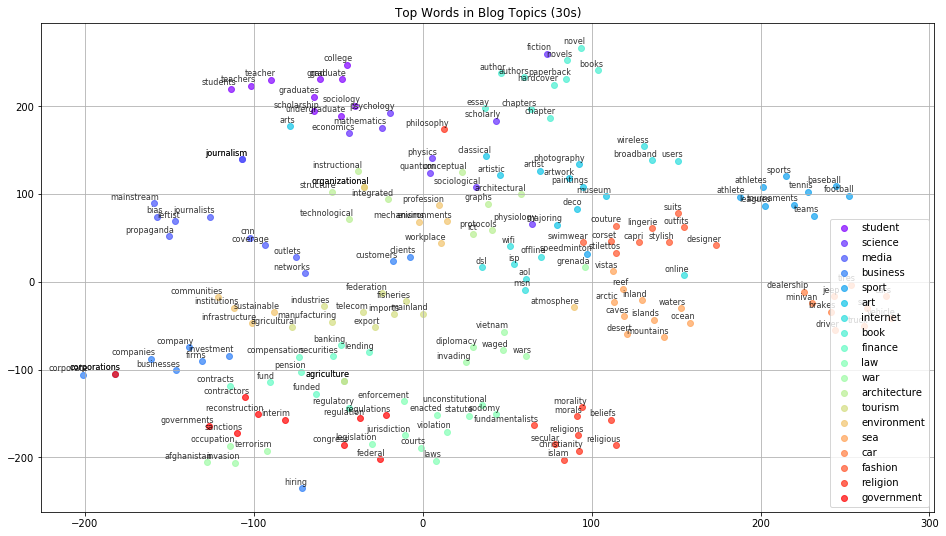

In [21]:
model = w2v_blog30

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.8, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Top Words in Blog Topics (30s)', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

### 10) Выводы:

#### Построенная общая карта слов отражает связь между темами и особенности лексического состава каждого топика.

1) Например, тема интернета, тема моря, тема машин и тема религии лежат сильно обособленно в общем словарном пространстве, в то время как темы окружающей среды , медиа и моды достаточно близки и даже пересекаются. Темы науки и образования сильно пересекаются.

2) Ожидаемо близкими словами к теме интернета являются «broadband, online, web», неожиданными, например, для темы правительства оказались слова «govt, mandate», для темы туризма — «bangladesh, andhra».

#### Видно, что «карта слов» имеет определенные возрастные зависимости, проявляющиеся в расстоянии между темами, в самых близких словах в теме (что отражает контекст использования). Вот некоторые замеченные особенности:

1) Например, для темы спорта популярными словами являются: 10s — «soccer, rugby»; 20s — «gymnastic, olympics»; 30s — «teams, tournaments» (выбраны ярко отличающиеся примеры). Для темы литературы: 10s — «manga»; 20s — «comics»; 30s — «hardcover». Это может давать представление о предпочтениях разных возрастных групп в спорте, литературе (и других темах).

2) Тема образования наиболее ярко выделена и обособлена у поколения 20s, темы религии, туризма и машин сильно обособлены у всех поколений, а тема моды обособлена у поколений 10s, 20s и смешана с темой искусства у поколения 30s.

Таким образом, «карты слов» могут давать важную информацию о предпочтениях разных групп пользователей, а также об устоявшихся ассоциативных связях.